In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import statistics 
import plotly
import cufflinks
import seaborn as sns

np.random.seed(123)

In [81]:
import plotly.express as px
import plotly.offline as pyo
from plotly.offline import plot
from plotly.tools import mpl_to_plotly


# Markowitz Portfolio Optimization (Modern Portfolio Theory)

The following source was used as inspiration and instruction for this investigation into Modern Portfolio Theory (MPT): [https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/](https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/ )

## Library Explanation
- **cvxopt:** Python Software for Convex Optimization - CVXOPT is a free software package for convex optimization based on the Python programming language. 
- **plotly:** Plotly is a free and open-source graphing library for Python. Plotly is well suited for creating interactive visualizations for web-based interactions
    - Maplotlib is a great starting tool.
    - Seaborn is fantastic for creating complex visuals with minimal code. 
- **cufflinks:** Allows for direct plotting from a Pandas dataframe using Plotly   

1. ## Simulate random asset return data.

_Returns represent the gains or losses experienced by an investor over the course of holding the asset_

Assuming that there exist 4 assets, to simulate a return over 1000 intervals representing the holding time of each asset.

The below visualization showcases the Normal or Gaussian Distribution sampled from. 

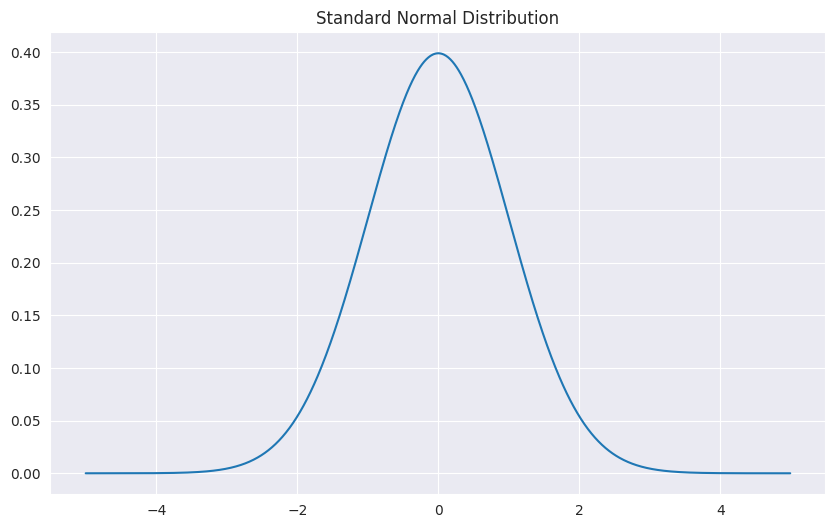

In [82]:
fig = plt.figure(figsize=(10, 6))
x_range = np.arange(-5, 5, 0.01)
mean = 0
sd = 1
plt.plot(x_range, norm.pdf(x_range, mean, sd))
plt.title('Standard Normal Distribution')
plt.show()

In [83]:
asset_no = 4
obs_no = 1000

asset_returns = np.random.randn(asset_no, obs_no)

The `iplot_mpl` allows for the creation of an interactive plot inside of a Jupyter notebook

In [84]:
fig = plt.figure(figsize=(20, 12))
plt.plot(asset_returns.T, alpha=0.4)
plt.xlabel('Time')
plt.ylabel('Asset returns')

plotly_fig = mpl_to_plotly(fig)
pyo.init_notebook_mode(connected=True)
pyo.iplot(plotly_fig, filename='random returns')

2. #### Create random weights to serve as portfolios
The combination of the above random returns combined with sets of random weights allows for the creation of a wide range of portfolios, which have different returns and risks (standard deviation)

_The random weights determine the proportion of your investment allocated to each asset. Note, the sum of weights per portfolio must sum to 1 for a fully invested portfolio_

In [85]:
def random_weighting(n):
    """Produce n random weights for each of the n assets to provide a full investment portfolio accross the available assets"""
    k = np.random.rand(n)  # Produces 4 random values between [0, 1] from a uniform distribution
    return k / sum(k)

In [86]:
portfolio_weighting_1 = random_weighting(asset_no)
print(portfolio_weighting_1)
assert(sum(portfolio_weighting_1) == 1)

[0.54066805 0.2360283  0.11660484 0.1066988 ]


3. ## Calculate Expected Return for each portfolio

The expected return equation is: 

$$R = p^Tw$$
Where: 
- R -> The expected return
- $p^T$ -> Transpose for the vector of the mean of the mean returns for each time series (and asset)
- w -> The weight vector of the portfolio

In [87]:
p = np.asmatrix(np.mean(asset_returns, axis=1))  # Axis=1 means calculation along row
print(p)

[[-0.03956414  0.00838917  0.01035309  0.06647869]]


In [88]:
w =np.asmatrix(portfolio_weighting_1)
print(w)

[[0.54066805 0.2360283  0.11660484 0.1066988 ]]


In [89]:
R = w * p.T
print(R)

[[-0.01111057]]


The resulting expected return is a scaler result. 

4. ## Calculate Standard deviation

Standard deviation is a statistical measure of the amount of variation or dispersion in a set of values. 
To calculate the standard deviation for Markowitz Portfolio Optimization, the following equation is used (making use of the covariance matrix)

$$\sigma = \sqrt{w^TCw}$$

$w^TC$ represents the weighted sum of the covariances between the assets in the portfolio. -> produces a row vector
$w^TCw$


Where:
- C -> The covariance NxN matrix. Keep in mind that a covariance matrix is a measure of how much asset returns change together.
- w -> The weight vector of the portfolio

**The covariance matrix diagonal represent the variance (standard deviation squared) of each individual asset. Simple standard deviation is calculated without considering the covariances.**

**Standard deviation is the spread of a group of numbers from the mean. The variance measures the average degree to which point differs from the mean.**

In [90]:
C = np.asmatrix(np.cov(asset_returns))
print(C)

[[ 1.00257827 -0.03002349 -0.03186494 -0.02721775]
 [-0.03002349  0.91870101 -0.01260472 -0.03738563]
 [-0.03186494 -0.01260472  0.96422476  0.00638768]
 [-0.02721775 -0.03738563  0.00638768  0.97918859]]


The weighted sum of the covariances between the assets in the portfolio

In [91]:
w * C

matrix([[0.52835594, 0.19514792, 0.09291141, 0.08168325]])

The sum of the covariances for each asset is then applied to the asset weighting to determine the total variance of the portfolio

**A covariance near 0 indicates very little or no relationship. A high positive covariance indicates a positive linear relationship. A high negative covariance indicates a negative linear relationship**

In [92]:
std_cov = np.sqrt(w * C * w.T)
print(std_cov)

[[0.5926846]]


5. ## Portfolio Simulation to extract standard deviation and expected return

In [93]:
def simulation(returns: np.matrix, no_simulations):
    exp_returns = []
    st_deviations = []
    for n in range(no_simulations):
        portfolio_investment = random_weighting(returns.shape[0])
        
        p = np.asmatrix(np.mean(asset_returns, axis=1))  # Mean returns for each asset
        w = np.asmatrix(portfolio_investment)  # Portfolio investment weightings
        R = w * p.T  # The expected return for the portfolio
        
        C = np.asmatrix(np.cov(returns))
        std_cov = np.sqrt((w * C) * w.T)
        
        exp_returns.append(R.tolist()[0][0])
        st_deviations.append(std_cov.tolist()[0][0])
        
    return exp_returns, st_deviations
        
        

In [94]:
expected_returns, std_deviations = simulation(asset_returns, 1000)

In [95]:
print("Sample expected returns: ", expected_returns[:5])

Sample expected returns:  [0.008567717027594398, 0.02412320942011314, 0.007014186599554977, 0.03217341284162501, 0.018501057173412418]


In [96]:
print('Sample standard deviations: ', std_deviations[:5])

Sample standard deviations:  [0.5760017178166735, 0.5143400399782871, 0.49166996633972865, 0.5727923861449332, 0.48713522041981105]


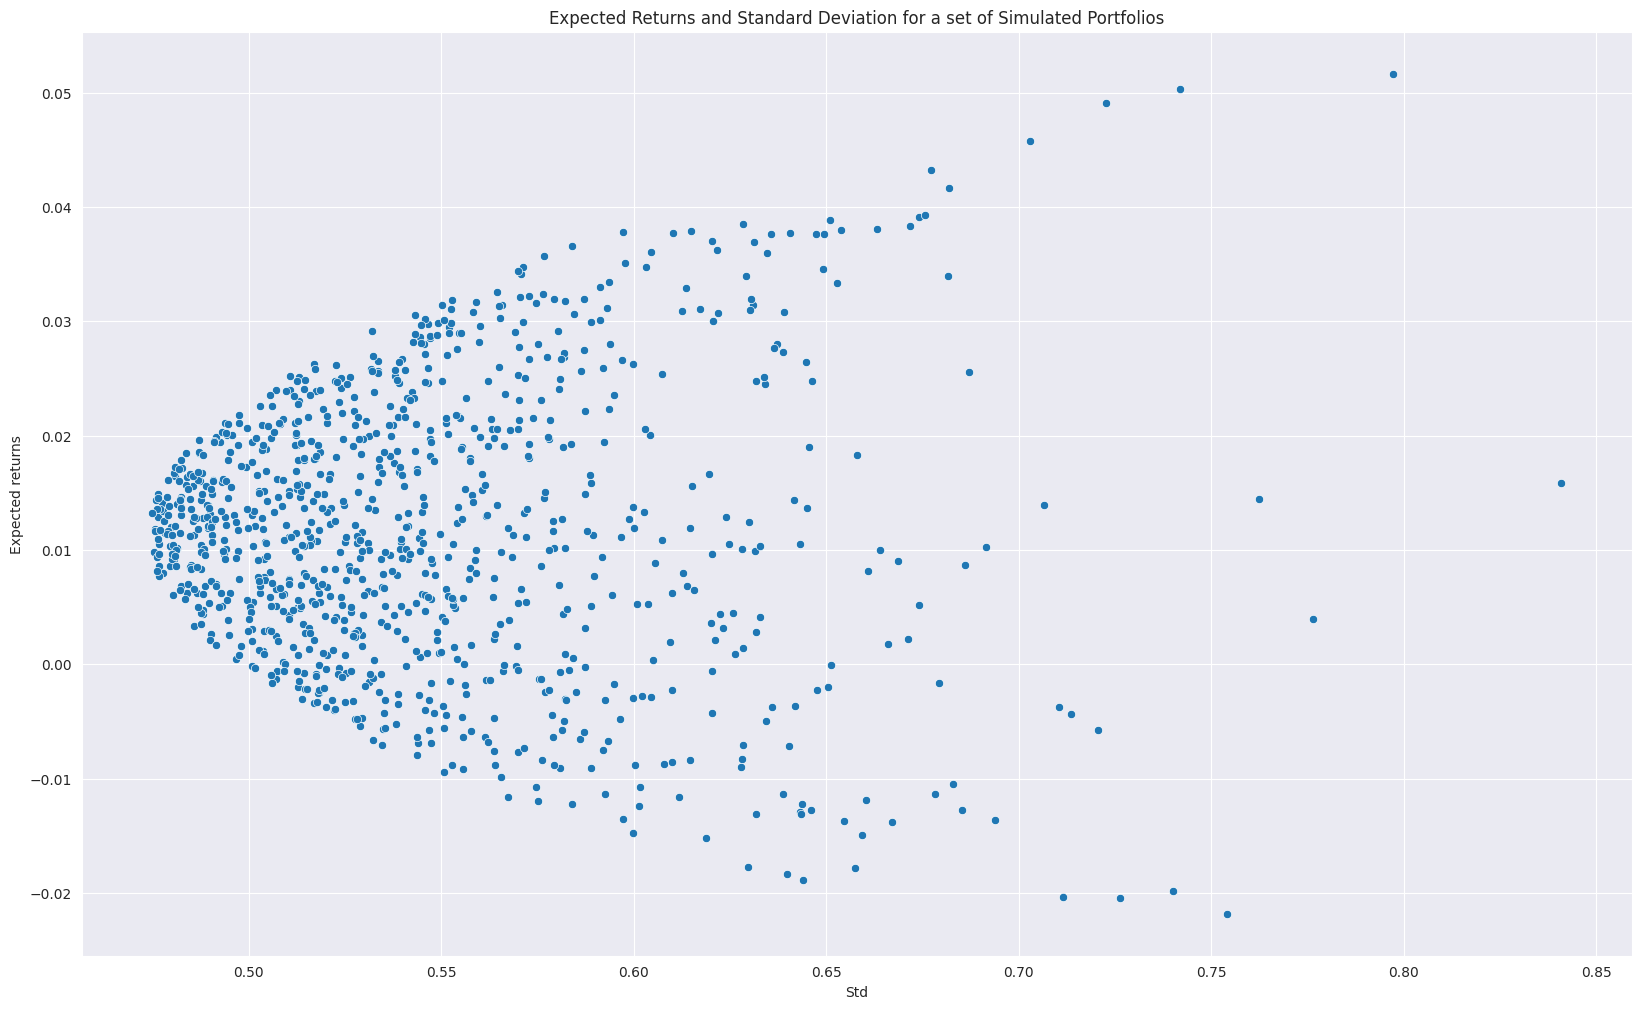

In [133]:
fig = plt.figure(figsize=(20, 12))
sns.scatterplot(x=std_deviations, y=expected_returns)

plt.xlabel('Std')
plt.ylabel('Expected returns')
plt.title('Expected Returns and Standard Deviation for a set of Simulated Portfolios')
plt.show()

6. ## Calculate the Efficient Frontier
The following process will make use of the `cvxopt` library to perform convex optimization on the above expected return, standard deviation set. 

**In my portfolio I want to choose my weightings in each asset as to maximize my return, while minimizing my variance.**

Based on the above, I want to minimize my variance: 
$$\min{w^TCw}$$

For a given portfolio investment ($w$), while keeping the sum of all weights equal to 1. 

The problem can be solved quadratically using Lagrangian multipliers, taking the form of the following optimization problem (source: [https://youtu.be/8jKrnUfIYEg](https://youtu.be/8jKrnUfIYEg)

Portfolio variance: $\min{0.5 * w^TCw}$
such that $R^Tw \geq \mu_b$  (The portfolio return is above $\mu_b$
and $e^Tw = 1$ where $e$ is a vector of 1's to enforce a complete portfolio

Create a set of `mu's`. This set of values creates a set of expected returns. 
By specifying a range of expected returns (`mus's`), you can solve the optimization problem for each expected return to find the portfolio that minimizes the risk, subject to the expected return. 

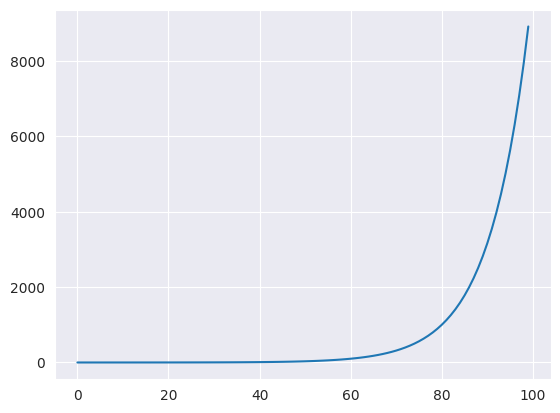

In [102]:
N = 100
x = list(range(N))
mus = [10**(5.0 * t/ N - 1.0) for t in range(N)]
plt.plot(x, mus)
plt.show()

The next example showcases the calculation of the efficient frontier. 

In [107]:
n = len(asset_returns)
print(n)

4


In [104]:
# Create cvxopt matrices for calculations
S = opt.matrix(np.cov(asset_returns))  # Calculate the covariance matrix of the expected returns
print(S)

[ 1.00e+00 -3.00e-02 -3.19e-02 -2.72e-02]
[-3.00e-02  9.19e-01 -1.26e-02 -3.74e-02]
[-3.19e-02 -1.26e-02  9.64e-01  6.39e-03]
[-2.72e-02 -3.74e-02  6.39e-03  9.79e-01]


In [106]:
pbar = opt.matrix(np.mean(asset_returns, axis=1))  # Calculate the mean expected returns for each asset
print(pbar)

[-3.96e-02]
[ 8.39e-03]
[ 1.04e-02]
[ 6.65e-02]


Create a set of constraint matrices for the convex optimization problem

In [123]:
G = opt.matrix(-np.eye(n))  # Create a negative nxn identify matrix
h = opt.matrix(0.0, (n, 1))  # Create a nx1 0 vector
A = opt.matrix(1.0, (1, n))  # Create a 1xn 1 vector
b = opt.matrix(1.0)  # Create a simple 1x1 1 vector

In [132]:
value = mu * S
print(value)

[ 1.00e+03 -3.00e+01 -3.19e+01 -2.72e+01]
[-3.00e+01  9.19e+02 -1.26e+01 -3.74e+01]
[-3.19e+01 -1.26e+01  9.64e+02  6.39e+00]
[-2.72e+01 -3.74e+01  6.39e+00  9.79e+02]


$\mu * S$ Is a scaler return (mu) multiplied by the covariance matrix S

The following are the parameters of the Quadratic Programming function: 
```solvers.qp(P, q, G, h, A, b)```
- P: The quadratic cost matrix. It represents the coefficients of the quadratic terms in the objective function. In Portfolio optimization, it is often the covariance matrix of the asset returns scaled by some factor. It is used to control risk. 
- q: This is the linear cost vector. It represents the coefficients of the linear terms in the objective function. In portfolio optimization it represents the expected returns of the assets.
- G: This is the inequality constraint matrix. It defines the coefficients of the inequalities (constraints of the form **G**x <= h). In portfolio optimization this is often a negative identity matrix to ensure that portfolio weights are non-negative
- h: The right hand-side of the inequality constraints. Vector that specifies the upper bound for each constraint. It is often a set of 0's in portfolio optimization to ensure portfolio weights are non-negative. 
- A: This is the equality constraint matrix. It defines the coefficients of the equality constraints (constraints of the form **A**x = b). In portfolio optimization, it is a row vector of 1's ensuring the portfolio weights sum to 1.
- b: This is the right hand side of the equality constraints. In portfolio optimization, it is set to 1 to sure that the sum of the portfolio weights is 1.

In [130]:
# Calculate the efficient frontier for a single mu value
mu = mus[80]
print(mu)
ex_portfolio = solvers.qp(mu * S, -pbar, G, h, A, b)

1000.0
